In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from dateutil.parser import parse
import datetime as dt
from datetime import datetime, timedelta
import os
import json
from scipy import stats

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score

from get_metrics import get_metrics_regression, rmsle, mean_absolute_error
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, KFold
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from catboost import Pool
import optuna
import joblib
import requests
RAND = 10
N_FOLDS = 5

# 1. Описание задачи

Компания занимается розничной реализацией нефтегазопродуктов. Необходима модель для прогнозирования продаж нефтегазопродуктов физичесикм лицам на каждую дату в разрезе АЗС. Это позволит оптимизировать поставки и минимизировать простои в связи с отсутствием топлива, планировать проведение строительно-монтажных работ в часы наименьшей клиентской активности.   
**Данные по АЗС:** для прогнозирования продаж у нас имеется информация по транзакциям АЗС: номер станции, дата и время транзакции, масса отпущенного топлива клиенту, сорт нетфепродукта, номер топливно-раздаточной колонки, номер пистолета, номер резервуара и номер кассы.  
**Target**: MASSA_TN  
**Источник данных праздничных, предпраздничных, нерабочих дней:**  
https://raw.githubusercontent.com/d10xa/holidays-calendar/master/json/calendar.json  
**Задача регрессии**  
**Основные признаки:**  
- AZS_NUM - номер азс в числовом формате  
- AZS_NAME - номер азс в формате "АЗС 001"  
- FL_EVBDATE - дата транзакции  
- FL_EVBTIME - время транзакции  
- MASSA_TN - объём проданного топлива (уже переведён в тонны)  
- PROD_NAME - сорт нефтепродукта  
- KS_WRKPLACE - номер кассы  
- KS_EV_NAME - тип чека (продажа/возврат)  
- FL_TANK - номер резервуара  
- FL_TRK - номер ТРК
- FL_HAND - номер пистолета

# 2. Импорт данных и предобработка для уменьшения размера датасета

In [3]:
# 2019 год
path = "D:/QS/2019/oil/operational/preprocessed_operational/"
data = os.listdir(path)
concat_df = pd.DataFrame()
list_df = []
# цикл для считывания файлов из указанной директории
# фильтр по физическим лицам (т.к. модель буду строить только по фл)
# удаление лишних столбцов для уменьшения размера датасета
for x in data:
    month = pd.read_csv(path + x, parse_dates=['FL_EVBDATE']) \
    .query('type_client == "ФЛ"') \
    .drop(['TIME_KEY', 'PAY_NAME', 'FL_VOLUME', 'FL_MASSA', 'KS_DOCNUM'], axis=1)
    list_df.append(month)
df = pd.concat(list_df, axis=0, ignore_index=True)

# кол-во работавших касс на азс на дату
ks = df \
    .groupby(['AZS_NAME', 'FL_EVBDATE'], as_index=False) \
    .agg({'KS_WRKPLACE': 'nunique'}) \
    .rename(columns={'KS_WRKPLACE': 'cnt_ks'})

# кол-во резервуаров
tank = df \
    .groupby(['AZS_NAME', 'PROD_NAME', 'FL_EVBDATE'], as_index=False) \
    .agg({'FL_TANK': 'nunique'}) \
    .rename(columns={'FL_TANK': 'cnt_tank'})

# кол-во трк
trk = df \
    .groupby(['AZS_NAME', 'PROD_NAME', 'FL_EVBDATE'], as_index=False) \
    .agg({'FL_TRK': 'nunique'}) \
    .rename(columns={'FL_TRK': 'cnt_trk'})

# кол-во пистолетов
hand = df \
    .groupby(['AZS_NAME', 'FL_EVBDATE', 'PROD_NAME', 'FL_TRK', 'FL_HAND'], as_index=False) \
    .agg({'MASSA_TN': 'sum'}) \
    .groupby(['AZS_NAME', 'FL_EVBDATE', 'PROD_NAME', 'FL_TRK'], as_index=False) \
    .agg({'FL_HAND': 'nunique'}) \
    .groupby(['AZS_NAME', 'PROD_NAME', 'FL_EVBDATE'], as_index=False) \
    .agg({'FL_HAND': 'sum'}) \
    .rename(columns={'FL_HAND': 'cnt_hand'})

# агрегация объёмов продаж по: азс, дате, сорту + добавление кол-ва касс, резервуаров, 
# трк, пистолетов на дату
df_2019 = df \
    .groupby(['AZS_NAME', 'FL_EVBDATE', 'PROD_NAME'], as_index=False) \
    .agg({'MASSA_TN': 'sum'}) \
    .merge(ks, on=['AZS_NAME', 'FL_EVBDATE'], how='left') \
    .merge(tank, on=['AZS_NAME', 'FL_EVBDATE', 'PROD_NAME'], how='left') \
    .merge(trk, on=['AZS_NAME', 'FL_EVBDATE', 'PROD_NAME'], how='left') \
    .merge(hand, on=['AZS_NAME', 'FL_EVBDATE', 'PROD_NAME'], how='left')

In [4]:
# 2021 год
path = "D:/QS/2021/oil/operational/preprocessed_operational/"
data = os.listdir(path)
concat_df = pd.DataFrame()
list_df = []
for x in data:
    month = pd.read_csv(path + x, parse_dates=['FL_EVBDATE']) \
    .query('type_client == "ФЛ"') \
    .drop(['TIME_KEY', 'PAY_NAME', 'FL_VOLUME', 'FL_MASSA', 'KS_DOCNUM'], axis=1)
    list_df.append(month)
df = pd.concat(list_df, axis=0, ignore_index=True)

ks = df \
    .groupby(['AZS_NAME', 'FL_EVBDATE'], as_index=False) \
    .agg({'KS_WRKPLACE': 'nunique'}) \
    .rename(columns={'KS_WRKPLACE': 'cnt_ks'})

tank = df \
    .groupby(['AZS_NAME', 'PROD_NAME', 'FL_EVBDATE'], as_index=False) \
    .agg({'FL_TANK': 'nunique'}) \
    .rename(columns={'FL_TANK': 'cnt_tank'})

trk = df \
    .groupby(['AZS_NAME', 'PROD_NAME', 'FL_EVBDATE'], as_index=False) \
    .agg({'FL_TRK': 'nunique'}) \
    .rename(columns={'FL_TRK': 'cnt_trk'})

hand = df \
    .groupby(['AZS_NAME', 'FL_EVBDATE', 'PROD_NAME', 'FL_TRK', 'FL_HAND'], as_index=False) \
    .agg({'MASSA_TN': 'sum'}) \
    .groupby(['AZS_NAME', 'FL_EVBDATE', 'PROD_NAME', 'FL_TRK'], as_index=False) \
    .agg({'FL_HAND': 'nunique'}) \
    .groupby(['AZS_NAME', 'PROD_NAME', 'FL_EVBDATE'], as_index=False) \
    .agg({'FL_HAND': 'sum'}) \
    .rename(columns={'FL_HAND': 'cnt_hand'})

df_2021 = df \
    .groupby(['AZS_NAME', 'FL_EVBDATE', 'PROD_NAME'], as_index=False) \
    .agg({'MASSA_TN': 'sum'}) \
    .merge(ks, on=['AZS_NAME', 'FL_EVBDATE'], how='left') \
    .merge(tank, on=['AZS_NAME', 'FL_EVBDATE', 'PROD_NAME'], how='left') \
    .merge(trk, on=['AZS_NAME', 'FL_EVBDATE', 'PROD_NAME'], how='left') \
    .merge(hand, on=['AZS_NAME', 'FL_EVBDATE', 'PROD_NAME'], how='left')

In [5]:
# 2022 год
path = "D:/QS/2022/oil/operational/preprocessed_operational/"
data = os.listdir(path)
concat_df = pd.DataFrame()
list_df = []
for x in data:
    month = pd.read_csv(path + x, parse_dates=['FL_EVBDATE']) \
    .query('type_client == "ФЛ"') \
    .drop(['TIME_KEY', 'PAY_NAME', 'FL_VOLUME', 'FL_MASSA', 'KS_DOCNUM'], axis=1)
    list_df.append(month)
df = pd.concat(list_df, axis=0, ignore_index=True)

ks = df \
    .groupby(['AZS_NAME', 'FL_EVBDATE'], as_index=False) \
    .agg({'KS_WRKPLACE': 'nunique'}) \
    .rename(columns={'KS_WRKPLACE': 'cnt_ks'})

tank = df \
    .groupby(['AZS_NAME', 'PROD_NAME', 'FL_EVBDATE'], as_index=False) \
    .agg({'FL_TANK': 'nunique'}) \
    .rename(columns={'FL_TANK': 'cnt_tank'})

trk = df \
    .groupby(['AZS_NAME', 'PROD_NAME', 'FL_EVBDATE'], as_index=False) \
    .agg({'FL_TRK': 'nunique'}) \
    .rename(columns={'FL_TRK': 'cnt_trk'})

hand = df \
    .groupby(['AZS_NAME', 'FL_EVBDATE', 'PROD_NAME', 'FL_TRK', 'FL_HAND'], as_index=False) \
    .agg({'MASSA_TN': 'sum'}) \
    .groupby(['AZS_NAME', 'FL_EVBDATE', 'PROD_NAME', 'FL_TRK'], as_index=False) \
    .agg({'FL_HAND': 'nunique'}) \
    .groupby(['AZS_NAME', 'PROD_NAME', 'FL_EVBDATE'], as_index=False) \
    .agg({'FL_HAND': 'sum'}) \
    .rename(columns={'FL_HAND': 'cnt_hand'})

df_2022 = df \
    .groupby(['AZS_NAME', 'FL_EVBDATE', 'PROD_NAME'], as_index=False) \
    .agg({'MASSA_TN': 'sum'}) \
    .merge(ks, on=['AZS_NAME', 'FL_EVBDATE'], how='left') \
    .merge(tank, on=['AZS_NAME', 'FL_EVBDATE', 'PROD_NAME'], how='left') \
    .merge(trk, on=['AZS_NAME', 'FL_EVBDATE', 'PROD_NAME'], how='left') \
    .merge(hand, on=['AZS_NAME', 'FL_EVBDATE', 'PROD_NAME'], how='left')

In [6]:
# 2023 год
path = "D:/QS/2023/oil/operational/preprocessed_operational/"
data = os.listdir(path)
concat_df = pd.DataFrame()
list_df = []
for x in data:
    month = pd.read_csv(path + x, parse_dates=['FL_EVBDATE']) \
    .query('type_client == "ФЛ"') \
    .drop(['TIME_KEY', 'PAY_NAME', 'FL_VOLUME', 'FL_MASSA', 'KS_DOCNUM'], axis=1)
    list_df.append(month)
df = pd.concat(list_df, axis=0, ignore_index=True)

ks = df \
    .groupby(['AZS_NAME', 'FL_EVBDATE'], as_index=False) \
    .agg({'KS_WRKPLACE': 'nunique'}) \
    .rename(columns={'KS_WRKPLACE': 'cnt_ks'})

tank = df \
    .groupby(['AZS_NAME', 'PROD_NAME', 'FL_EVBDATE'], as_index=False) \
    .agg({'FL_TANK': 'nunique'}) \
    .rename(columns={'FL_TANK': 'cnt_tank'})

trk = df \
    .groupby(['AZS_NAME', 'PROD_NAME', 'FL_EVBDATE'], as_index=False) \
    .agg({'FL_TRK': 'nunique'}) \
    .rename(columns={'FL_TRK': 'cnt_trk'})

hand = df \
    .groupby(['AZS_NAME', 'FL_EVBDATE', 'PROD_NAME', 'FL_TRK', 'FL_HAND'], as_index=False) \
    .agg({'MASSA_TN': 'sum'}) \
    .groupby(['AZS_NAME', 'FL_EVBDATE', 'PROD_NAME', 'FL_TRK'], as_index=False) \
    .agg({'FL_HAND': 'nunique'}) \
    .groupby(['AZS_NAME', 'PROD_NAME', 'FL_EVBDATE'], as_index=False) \
    .agg({'FL_HAND': 'sum'}) \
    .rename(columns={'FL_HAND': 'cnt_hand'})

df_2023 = df \
    .groupby(['AZS_NAME', 'FL_EVBDATE', 'PROD_NAME'], as_index=False) \
    .agg({'MASSA_TN': 'sum'}) \
    .merge(ks, on=['AZS_NAME', 'FL_EVBDATE'], how='left') \
    .merge(tank, on=['AZS_NAME', 'FL_EVBDATE', 'PROD_NAME'], how='left') \
    .merge(trk, on=['AZS_NAME', 'FL_EVBDATE', 'PROD_NAME'], how='left') \
    .merge(hand, on=['AZS_NAME', 'FL_EVBDATE', 'PROD_NAME'], how='left')

In [7]:
df = pd.concat([df_2019, df_2021, df_2022], ignore_index=True)
del df_2019
del df_2021
del df_2022

In [9]:
df.to_csv(r"C:\Users\ozhiganov_dv\Jupyter\PyMagic\09. Pet-project\data\df_1", index=False)

# 3. Exploratory data analysis

In [10]:
df = pd.read_csv(r"C:\Users\ozhiganov_dv\Jupyter\PyMagic\09. Pet-project\data\df_1",
                parse_dates=['FL_EVBDATE'])

In [11]:
df.describe().round(2)

,MASSA_TN,cnt_ks,cnt_tank,cnt_trk,cnt_hand
count,953970.00,953970.00,953970.00,953970.00,953970.00
mean,1.77,2.62,1.05,4.44,4.48
std,1.76,1.07,0.22,2.07,2.11
min,0.00,1.00,1.00,1.00,1.00
25%,0.54,2.00,1.00,4.00,4.00
50%,1.20,3.00,1.00,4.00,4.00
75%,2.41,3.00,1.00,6.00,6.00
max,26.02,7.00,3.00,18.00,18.00


In [12]:
df.describe(include='object')

,AZS_NAME,PROD_NAME
count,953970,953970
unique,262,11
top,АЗС 520,Бензин АИ-95
freq,6659,245785


целевая переменная - MASSA_TN (продажи/объём продаж)  
**Гипотезы:**  
- сорт влияет на объём продаж в адрес фл  
- чем больше кол-во касс на АЗС - тем выше продажи 
- чем больше кол-во ТРК - тем выше продажи 
- продажи зависят от АЗС
- кол-во резервуаров влияет на продажи
- кол-во пистолетов оказывает влияние на объём продаж  
- продажи подвержены фактору сезонности

## Target

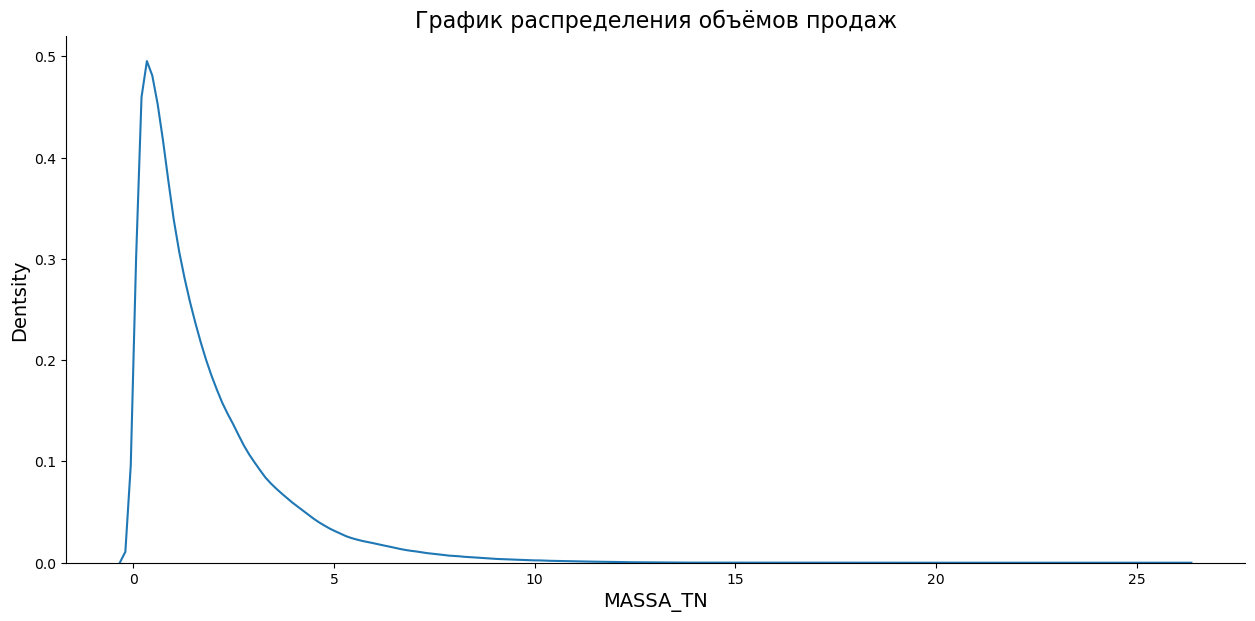

In [13]:
sns.displot(
    data=df,
    x='MASSA_TN',
    kind="kde",
    common_norm=False,
    height=6,
    aspect=2.1)

plt.title('График распределения объёмов продаж', fontsize=16)
plt.xlabel('MASSA_TN', fontsize=14)
plt.ylabel('Dentsity', fontsize=14)

plt.show();

In [6]:
test_shapiro = stats.shapiro(df['MASSA_TN'])

print(test_shapiro)

if test_shapiro.pvalue < 0.05:
    print('Распределение не нормальное')
else:
    print('Распределение нормальное')

ShapiroResult(statistic=0.8076745271682739, pvalue=0.0)
Распределение не нормальное


C:\Users\ozhiganov_dv\Anaconda3\lib\site-packages\scipy\stats\_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


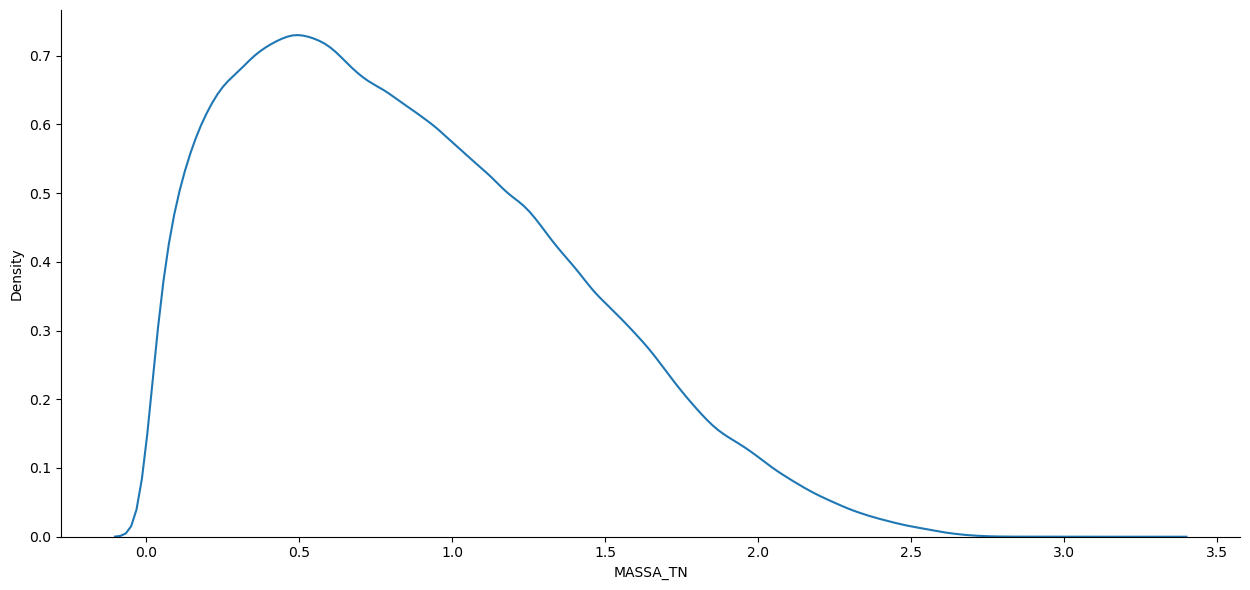

In [7]:
sns.displot(np.log(df['MASSA_TN'] + 1),
            kind='kde',
            height=6,
            aspect=2.1)
plt.show();

In [8]:
df_log = df.copy()
df_log['massa_log'] = np.log(df['MASSA_TN'] + 1)

In [9]:
test_shapiro = stats.shapiro(df_log['massa_log'])

print(test_shapiro)

if test_shapiro.pvalue < 0.05:
    print('Распределение не нормальное')
else:
    print('Распределение нормальное')

ShapiroResult(statistic=0.9636218547821045, pvalue=0.0)
Распределение не нормальное


C:\Users\ozhiganov_dv\Anaconda3\lib\site-packages\scipy\stats\_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


## Гипотеза 1  
сорт влияет на объём продаж в адрес фл

C:\Users\ozhiganov_dv\Anaconda3\lib\site-packages\seaborn\distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


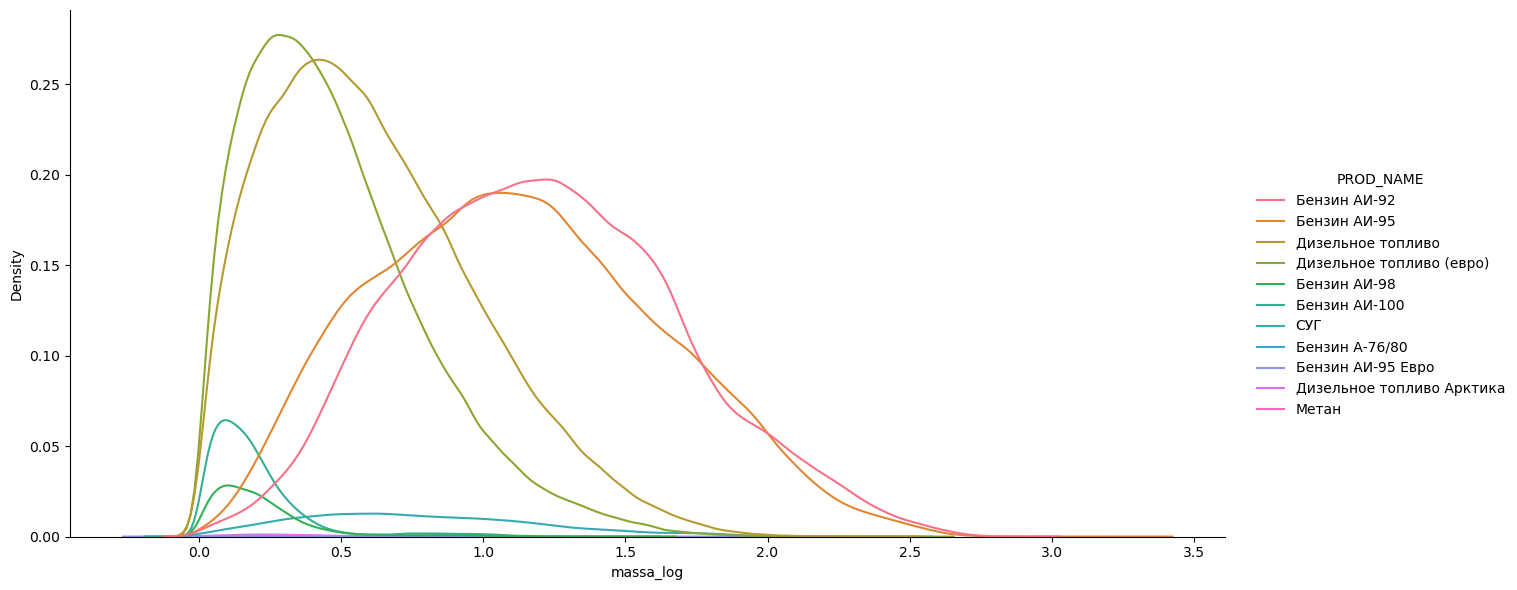

In [10]:
sns.displot(data=df_log,
            x='massa_log',
            hue='PROD_NAME',
            kind='kde',
            height=6,
            aspect=2.1)
plt.show();

In [11]:
df \
    .groupby('PROD_NAME', as_index=False) \
    .agg({'MASSA_TN': 'count'})

,PROD_NAME,MASSA_TN
0,Бензин А-76/80,2
1,Бензин АИ-100,16730
2,Бензин АИ-92,244706
3,Бензин АИ-95,245785
4,Бензин АИ-95 Евро,197
5,Бензин АИ-98,8363
6,Дизельное топливо,232398
7,Дизельное топливо (евро),192244
8,Дизельное топливо Арктика,452
9,Метан,12


- Бензин А-76/80 - удалю строки;

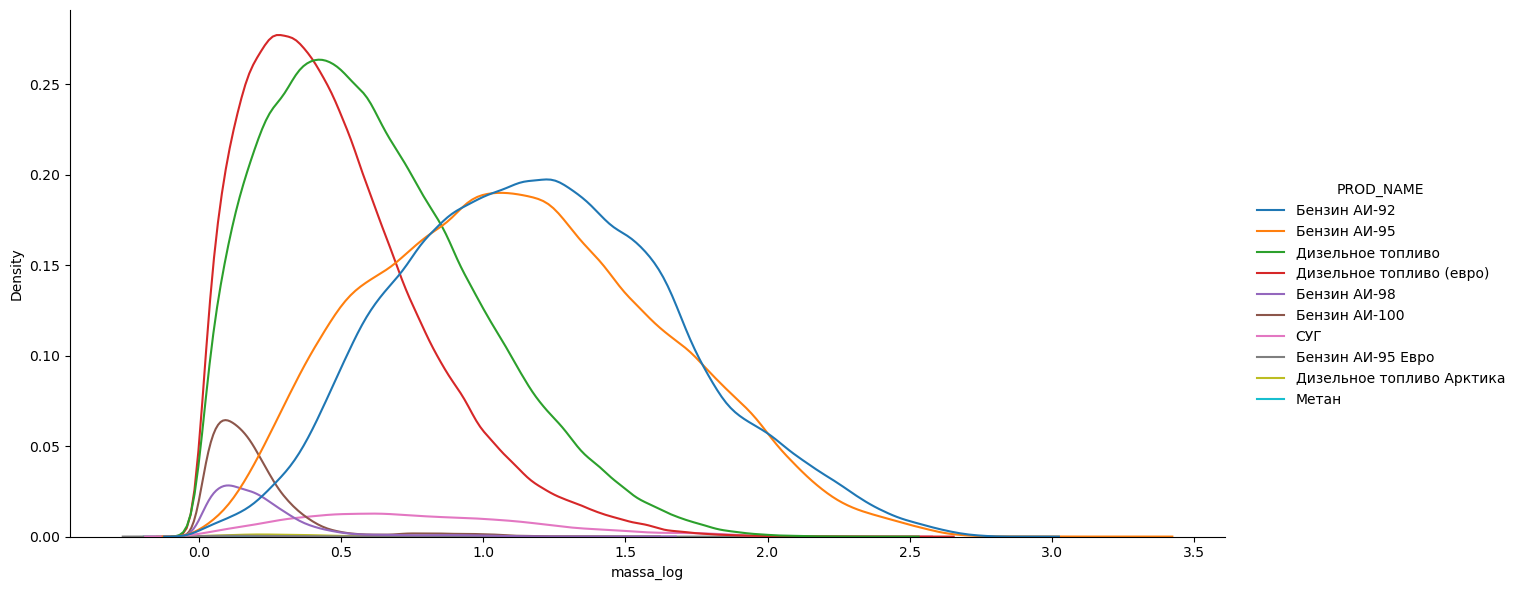

In [12]:
df = df[df['PROD_NAME'] != 'Бензин А-76/80']
df_log = df_log[df_log['PROD_NAME'] != 'Бензин А-76/80']

sns.displot(data=df_log,
            x='massa_log',
            hue='PROD_NAME',
            kind='kde',
            height=6,
            aspect=2.1)
plt.show();

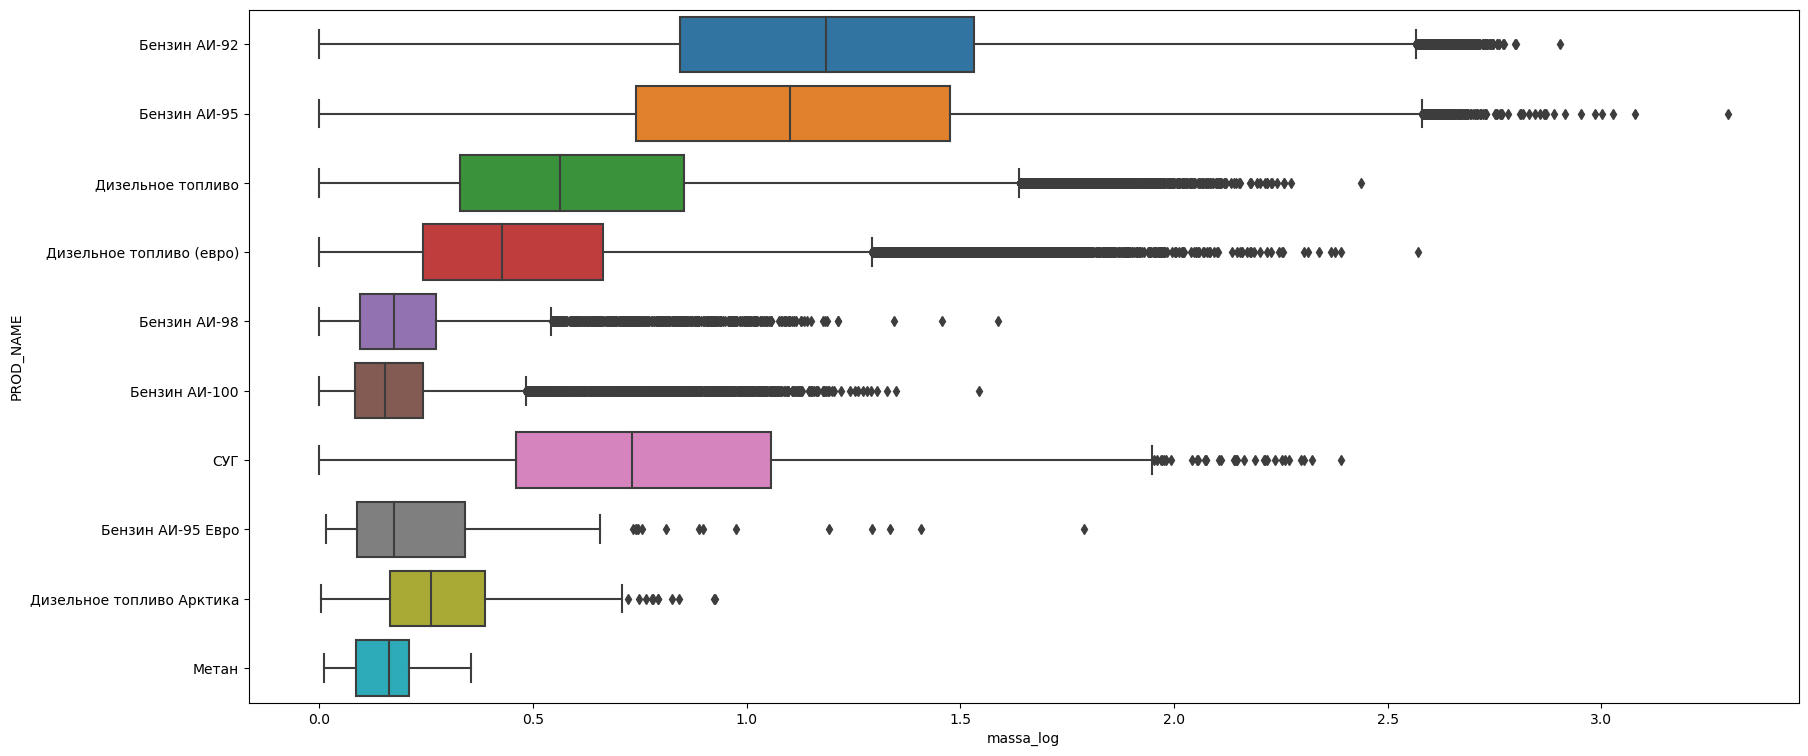

In [13]:
plt.figure(figsize=(20, 9))
sns.boxplot(data=df_log, x='massa_log', y='PROD_NAME')
plt.show();

Вывод: 
- лучше всего продаются 2 сорта бензинов: Бензин АИ-92, Бензин АИ-95

## Гипотеза 2  
чем больше кол-во касс на АЗС - тем выше продажи

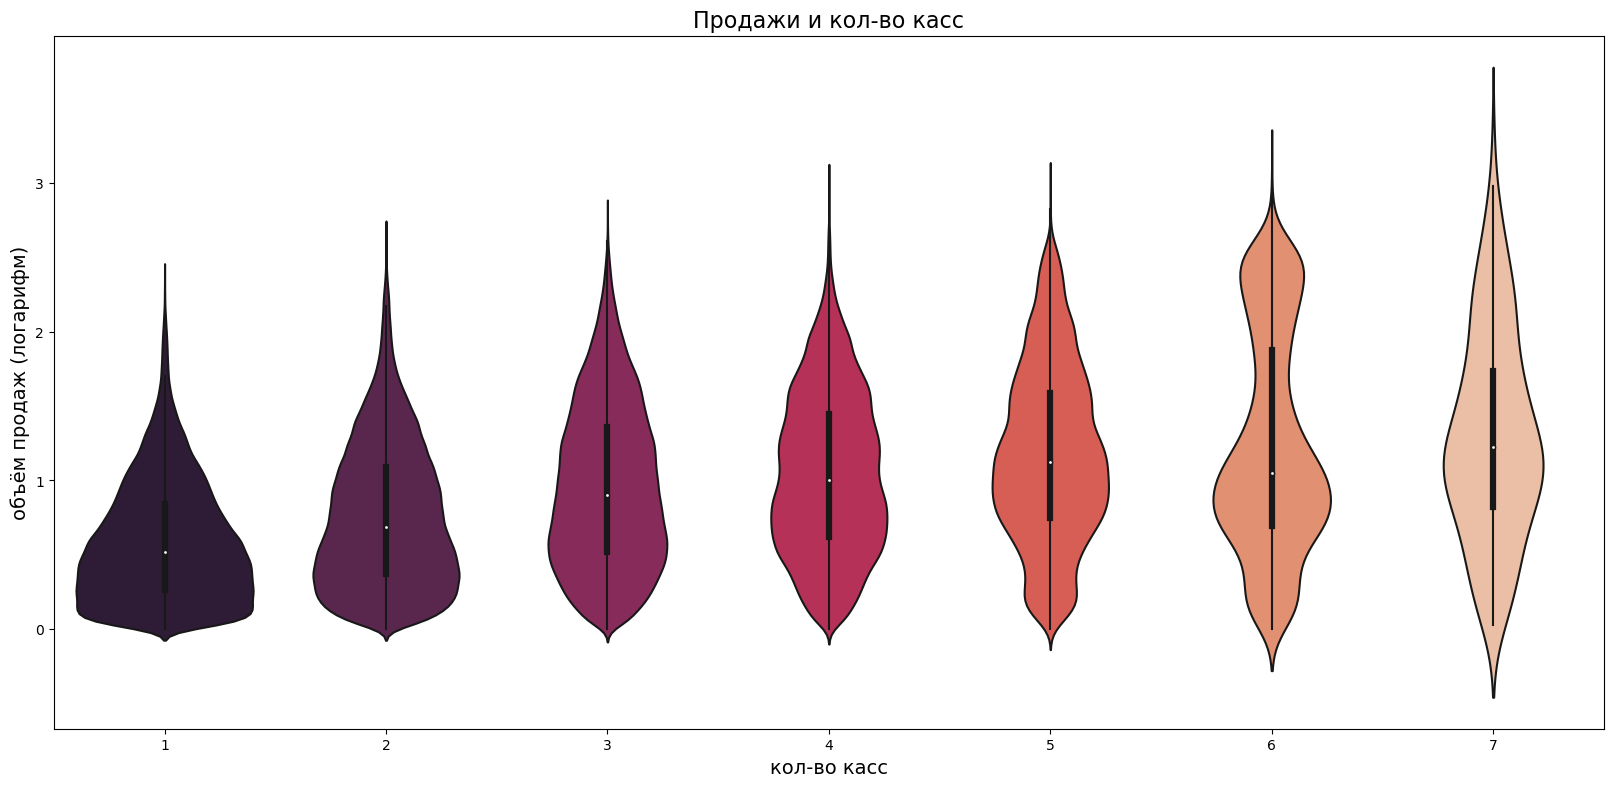

In [14]:
plt.figure(figsize=(20, 9))

sns.violinplot(x='cnt_ks', y='massa_log', data=df_log, palette='rocket')

plt.title('Продажи и кол-во касс', fontsize=16)
plt.ylabel('объём продаж (логарифм)', fontsize=14)
plt.xlabel('кол-во касс', fontsize=14)
plt.show()

Выводы:  
- АЗС с одной кассой показывают самые низкие продажи;  
- АЗС с 7-ю работающими кассами показывают незначительно выше продажи чем станции с 5-ю кассами;  
признак можно будет сгруппировать:  
- 1-я группа: станции с 1-й и 2-мя кассами
- 2-я группа: станции с 3-мя и 4-мя кассами  
- 3-я группа: станции с 5-ю и более кассами

## Гипотеза 3  
чем больше кол-во ТРК - тем выше продажи

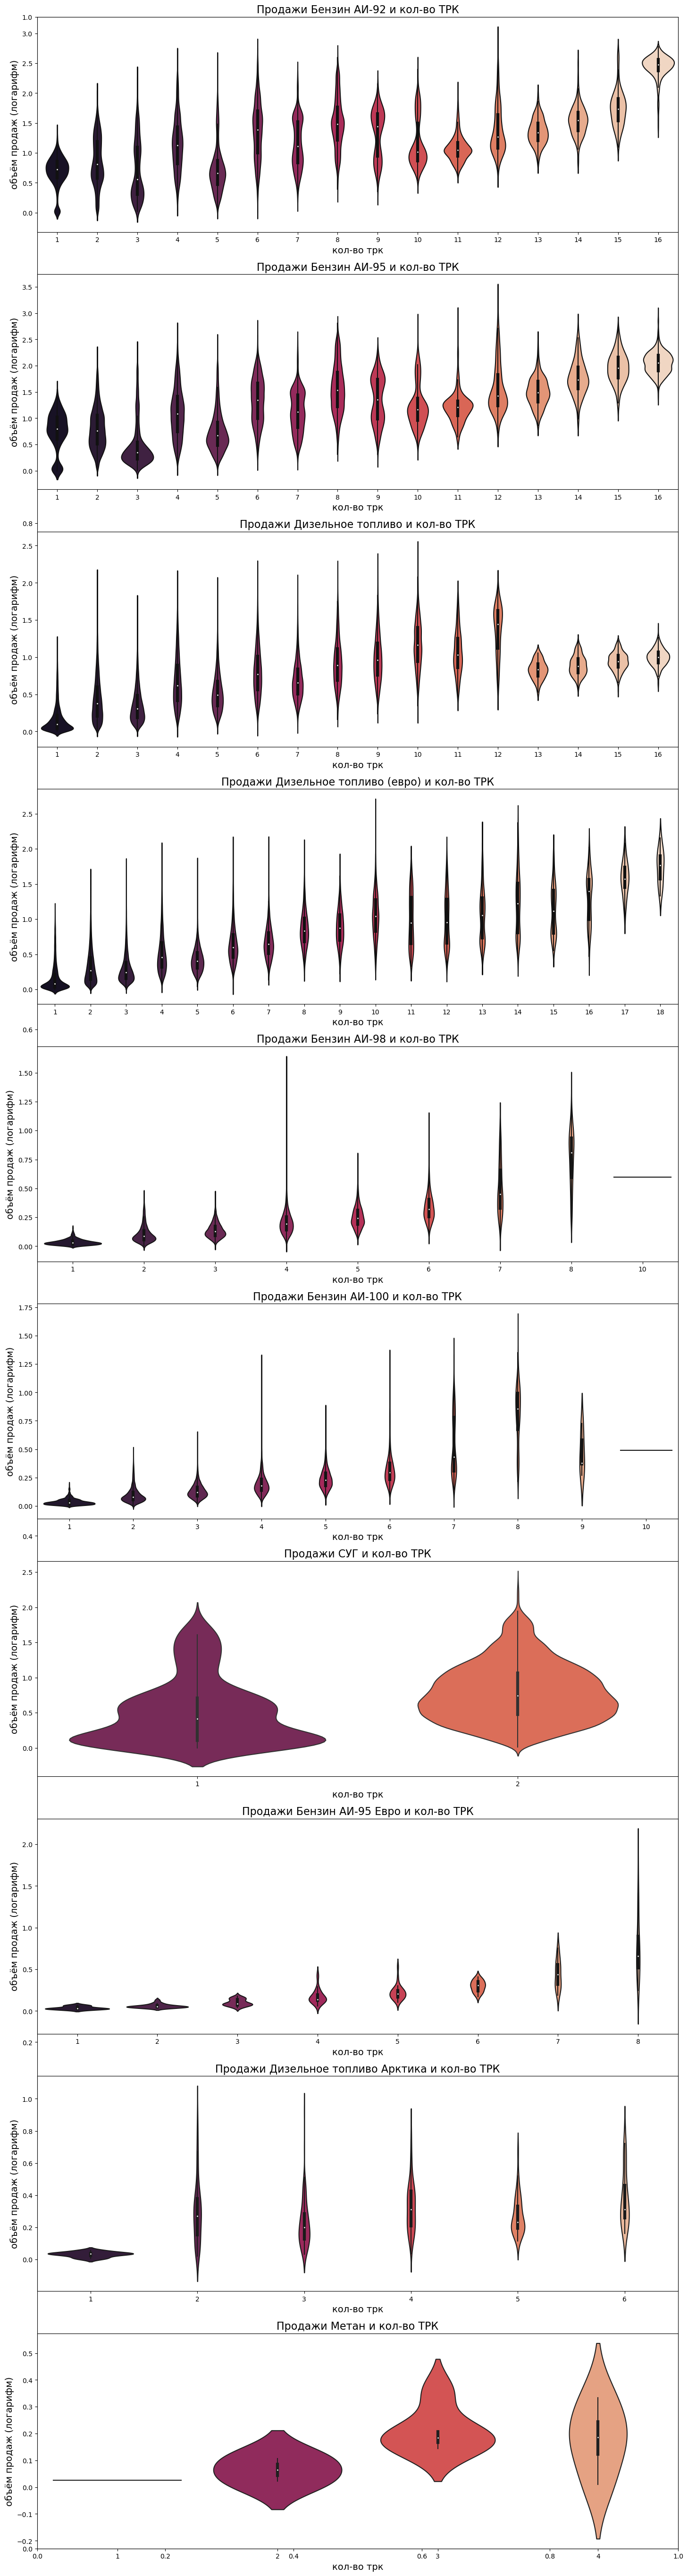

In [59]:
fig, axes = plt.subplots(figsize=(15, 55))
count_axes = len(df_log.PROD_NAME.unique())
list_products = df_log.PROD_NAME.unique()
n = 1

for x in list_products:
    ax = fig.add_subplot(count_axes, 1, n)
    sns.violinplot(x='cnt_trk', y='massa_log', data=df_log.query('PROD_NAME == @x'), palette='rocket')
    ax.set_title(f'Продажи {x} и кол-во ТРК', fontsize=16)
    ax.set_ylabel('объём продаж (логарифм)', fontsize=14);
    ax.set_xlabel('кол-во трк', fontsize=14);
    n+=1
        
plt.tight_layout()
plt.show();

Вывод:  
- кол-во трк влияет на продажи

## Гипотеза 4  
продажи зависят от АЗС

In [60]:
df_log \
    .groupby('AZS_NAME', as_index=False) \
    .agg({'MASSA_TN': 'mean'}) \
    .sort_values('MASSA_TN')

,AZS_NAME,MASSA_TN
55,АЗС 093,0.059411
155,АЗС 356,0.301703
144,АЗС 324,0.342774
252,АЗС 642,0.364990
130,АЗС 287,0.395311
...,...,...
37,АЗС 063,5.049295
214,АЗС 552,5.103601
45,АЗС 081,5.573745
132,АЗС 293,5.664680


Продажи на каждой АЗС разные. 

## Гипотеза 5  
кол-во резервуаров влияет на продажи

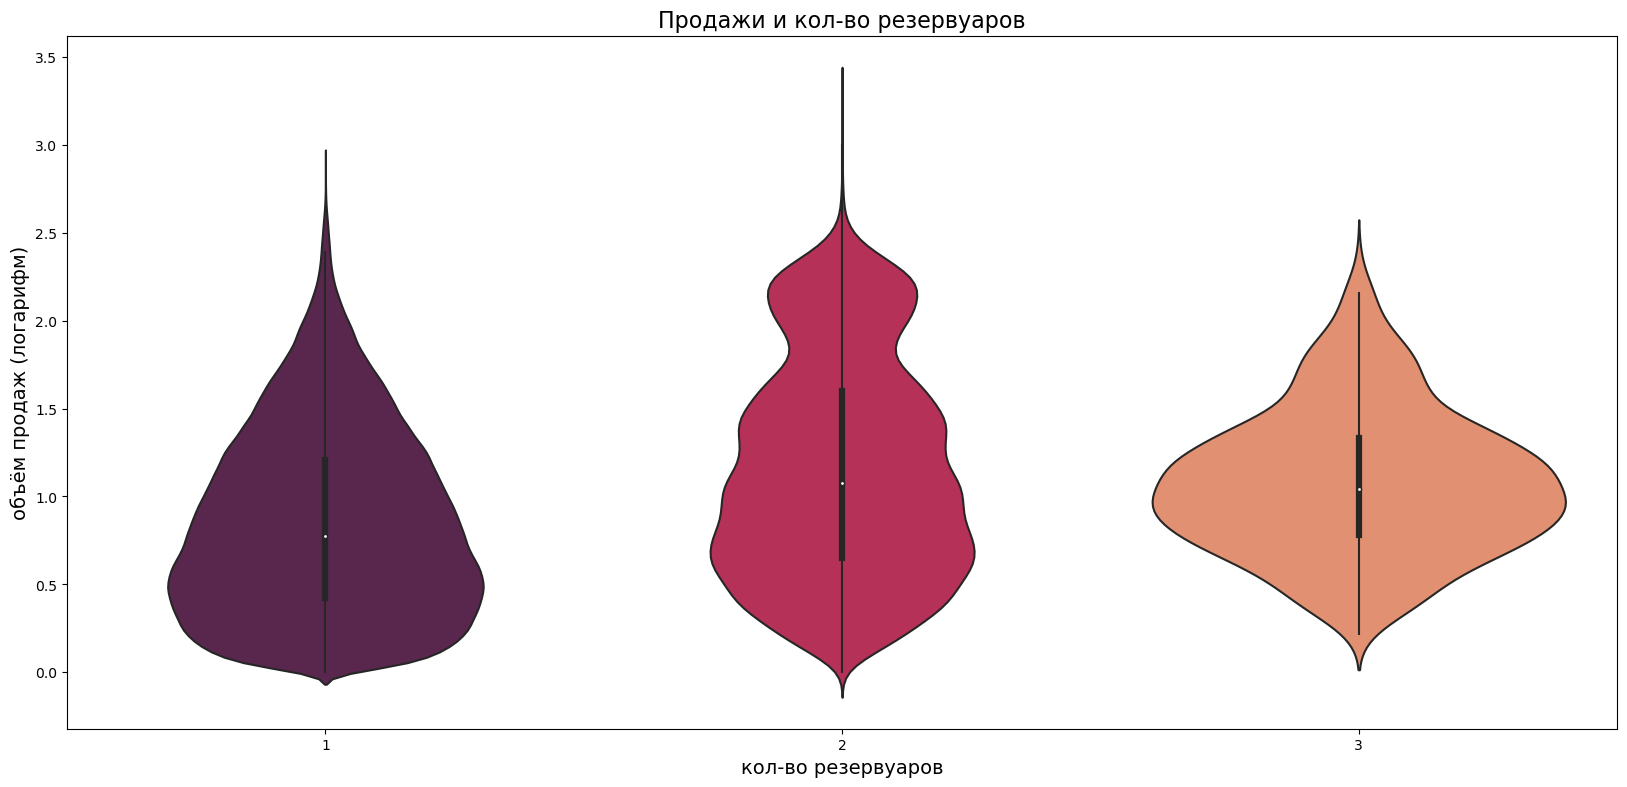

In [61]:
plt.figure(figsize=(20, 9))

sns.violinplot(x='cnt_tank', y='massa_log', data=df_log, palette='rocket')

plt.title('Продажи и кол-во резервуаров', fontsize=16)
plt.ylabel('объём продаж (логарифм)', fontsize=14)
plt.xlabel('кол-во резервуаров', fontsize=14)
plt.show()

Вывод:  
- кол-во резервуаров не оказывает влияния на объём продаж. Лишний признак - можно будет удалить.

## Гипотеза 6  
кол-во пистолетов оказывает влияние на объём продаж

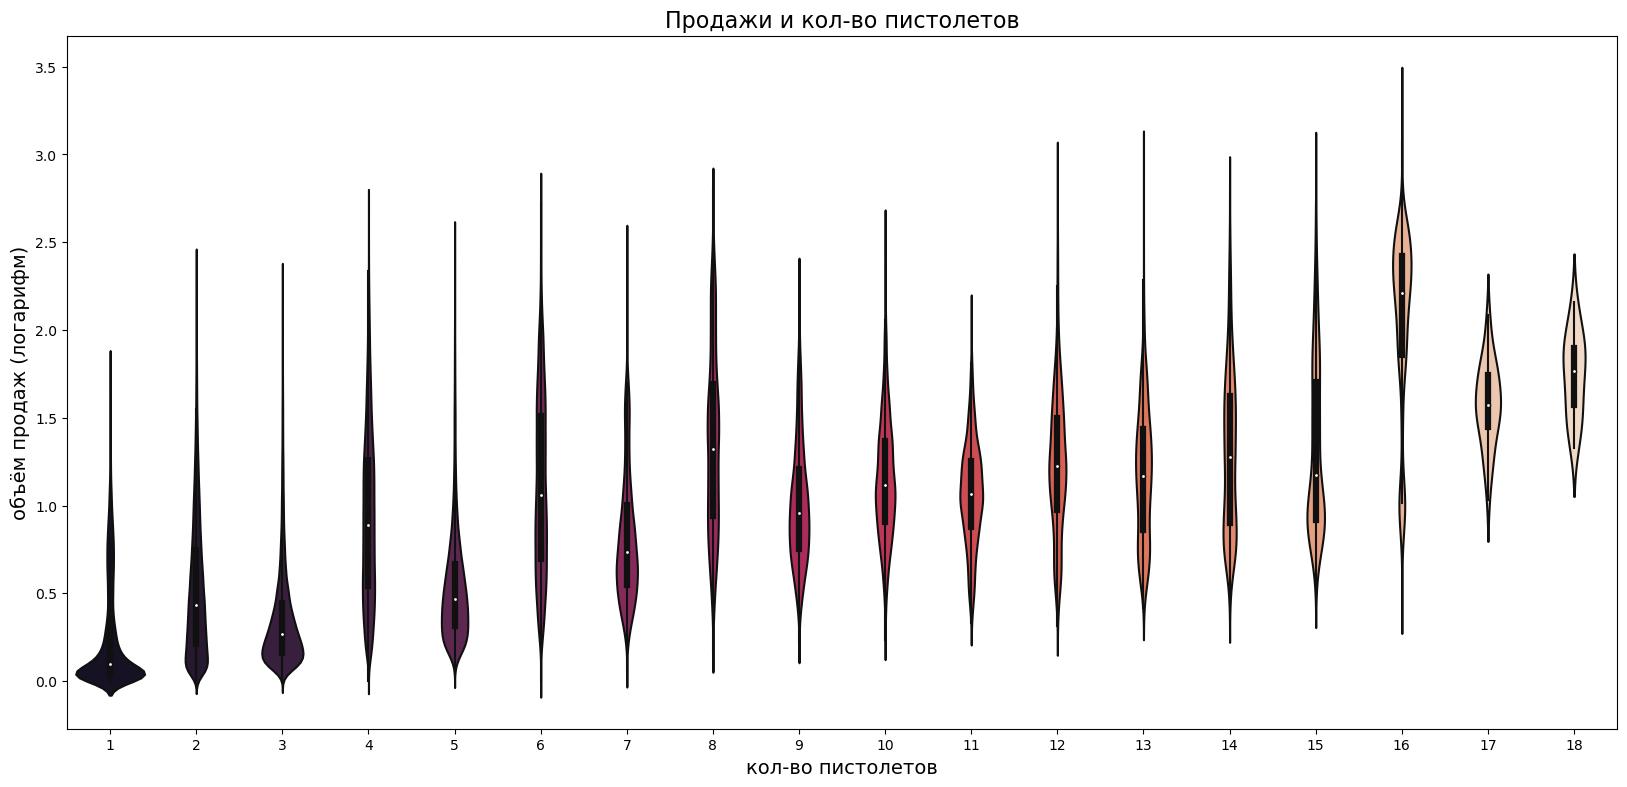

In [62]:
plt.figure(figsize=(20, 9))

sns.violinplot(x='cnt_hand', y='massa_log', data=df_log, palette='rocket')

plt.title('Продажи и кол-во пистолетов', fontsize=16)
plt.ylabel('объём продаж (логарифм)', fontsize=14)
plt.xlabel('кол-во пистолетов', fontsize=14)
plt.show()

Вывод:  
- кол-во пистолетов влияет на продажи

## Гипотеза 7  
Продажи подвержены фактору сезонности  

In [18]:
df_log.head(2)

,AZS_NAME,FL_EVBDATE,PROD_NAME,MASSA_TN,cnt_ks,cnt_tank,cnt_trk,cnt_hand,massa_log
0,АЗС 002,2019-01-01,Бензин АИ-92,0.761543,1,1,4,4,0.566190
1,АЗС 002,2019-01-01,Бензин АИ-95,0.867590,1,1,6,6,0.624649


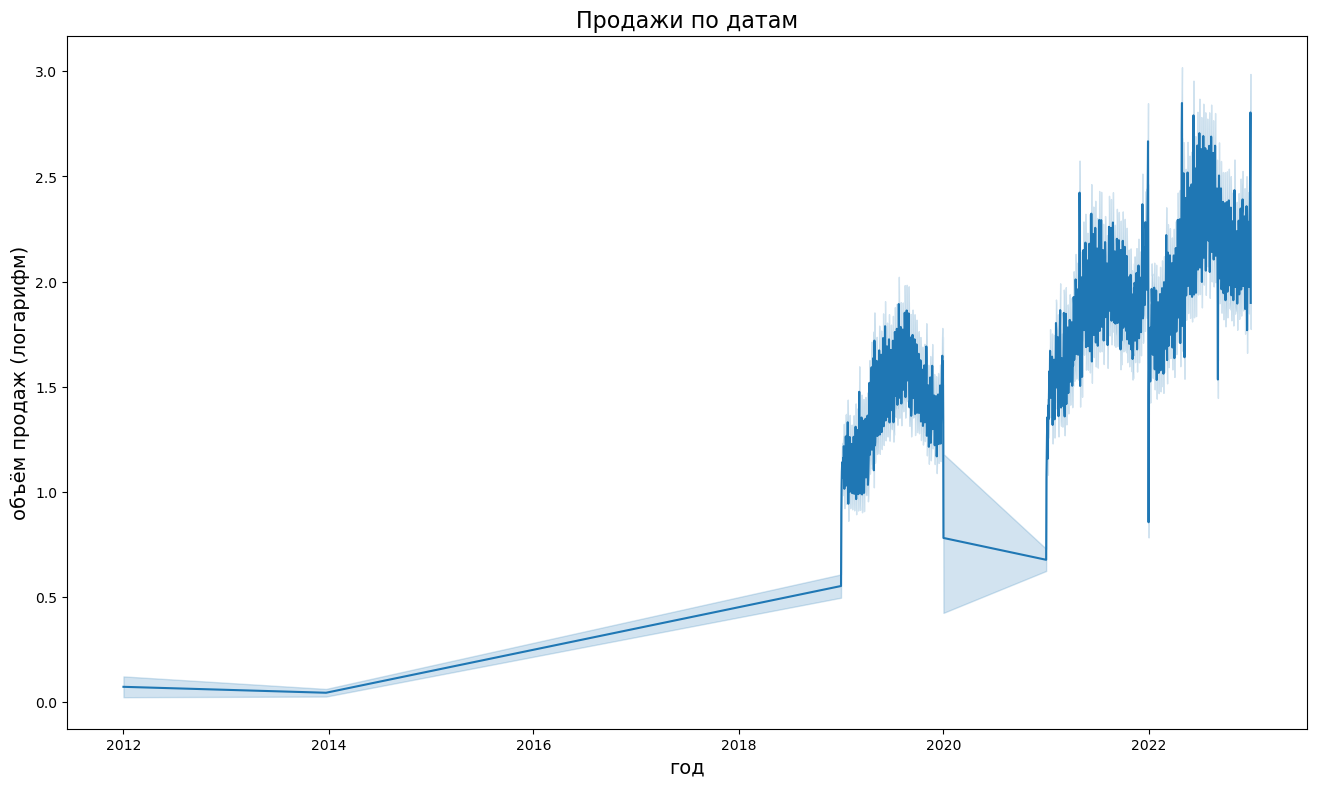

In [22]:
plt.figure(figsize=(16, 9))
sns.lineplot(x='FL_EVBDATE', y='MASSA_TN', data=df_log)
plt.title('Продажи по датам', fontsize=16)
plt.ylabel('объём продаж (логарифм)', fontsize=14)
plt.xlabel('год', fontsize=14)
plt.show();

Вывод:
- в данных есть выбросы (даты менее 2019 года и за 2020 год), исключу в feature engineering
- с каждым годом продажи увеличиваются
- пик продаж в середине года, т.е. присутствцет сезонная динамика

## Анализ распределений и линейной зависимости  

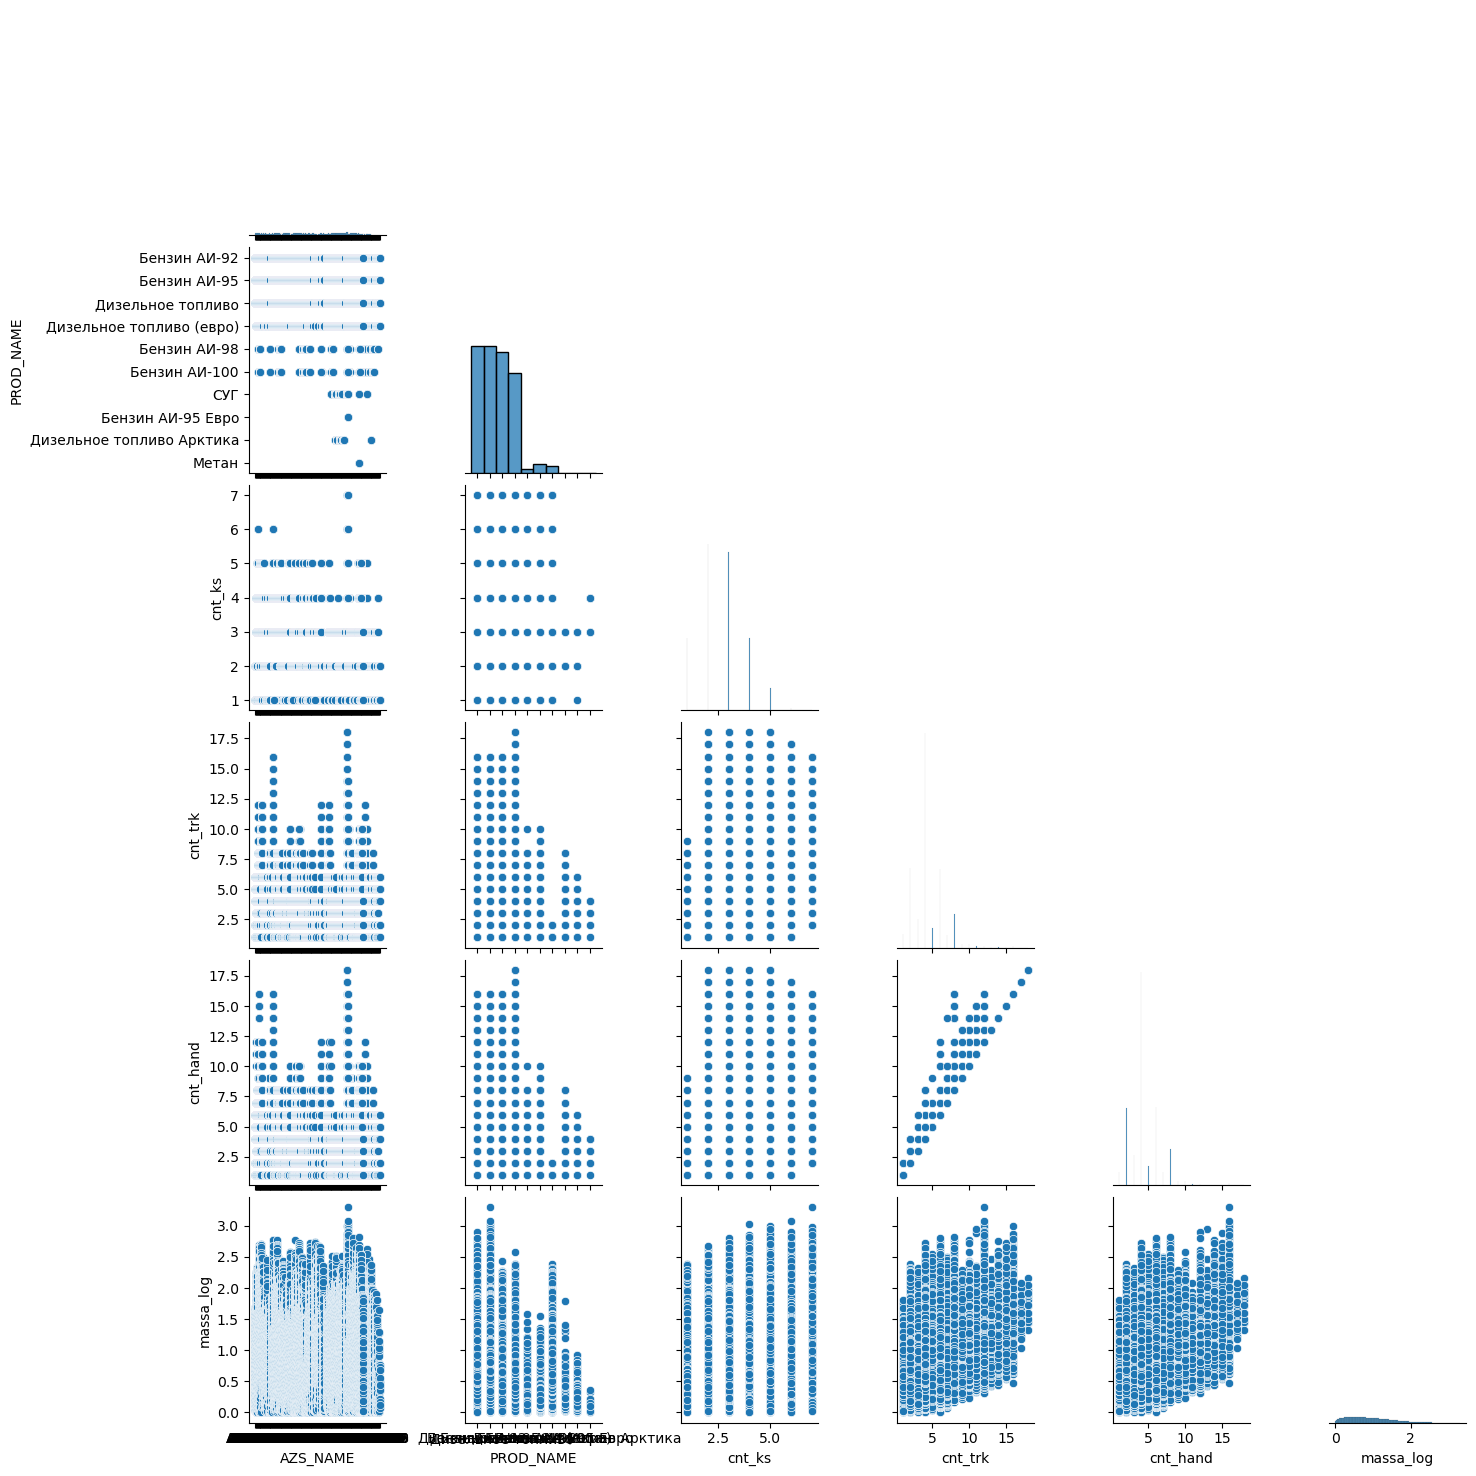

In [15]:
features = ['AZS_NAME', 'PROD_NAME', 'cnt_ks', 'cnt_trk', 'cnt_hand', 'massa_log']

sns.pairplot(df_log, vars=features, corner=True)
plt.show()

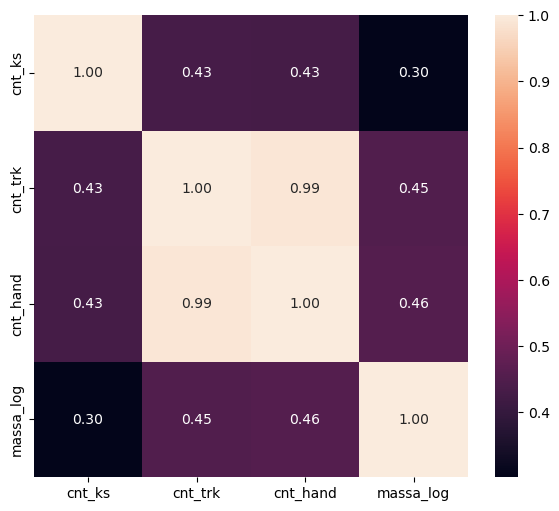

In [16]:
plt.figure(figsize=(7, 6))
sns.heatmap(df_log[features].corr(method='spearman'), annot=True, fmt='.2f')
plt.show();

1. Между признаками и целевой переменной нет линейной зависимости - модель линейной регрессии не применима;  
2. сильная корреляция между признаком 'cnt_trk' и 'cnt_hand'.

# 4. Feature engineering

## Получение новых признаков

### выделение года, месяца, дня недели
При проверке гипотезы 7 была выявлена сезонная динамика. Из даты извлеку год, месяц, день недели:
- продажи зависят от года, т.к. база привлекаемых и лояльных клиентов растёт
- продажи в августе отличаются от продаж в январе: август пик продаж - дачный сезон, тёплая погода, лёди активнее использую автомобили. В январе наоборот из-за праздников и холожов менее активно исаользуется личный автотранспорт.
- недельная динамика: в пятницу пик продаж - многие уезжают, в воскресенье сильный спад из-за выходного дня.

In [11]:
df['year'] = df.FL_EVBDATE.dt.year
df['month'] = df.FL_EVBDATE.dt.month
df['day'] = df.FL_EVBDATE.dt.day
df['day_of_week'] = df.FL_EVBDATE.dt.day_name()

### выходные, предпраздничные, праздничные, рабочие дни  
продажи в пятницу и выходные отличаются от продаж в будни  

In [18]:
def astype_col(data: pd.DataFrame, map_type_columns: dict) -> pd.DataFrame:
        """
        функция для замены типов данных в колонках
        :param data: подаваемый DataFrame
        :param map_type_columns: словарь с колонками и типом данных
        :return: датафрейм
        """
        return data.astype(map_type_columns)

In [12]:
# загрузка производственного календаря с GitHub
js = json \
    .loads(requests \
           .get('https://raw.githubusercontent.com/d10xa/holidays-calendar/master/json/calendar.json') \
           .text)

# добавление признаков выходной, праздничный, предпраздничный день 
for x in js:
    df[x] = df['FL_EVBDATE'] \
    .isin(pd.to_datetime(pd.DataFrame(js[x], columns=['FL_EVBDATE']).FL_EVBDATE, format="%Y-%m-%d"))

# замена булевого типа данных на int
type_col = {'holidays': 'int', 'preholidays': 'int', 'nowork': 'int'}
df = astype_col(data=df, map_type_columns=type_col)

### добавление вида нефтепродукта
добавлю признак по виду нефтепродукта в зависимости от сорта:  
- "бензин": Бензин АИ-92, Бензин АИ-95, Бензин АИ-98, Бензин АИ-100, Бензин АИ-95 Евро
- "дт" (дизельное топливо): Дизельное топливо, Дизельное топливо (евро), Дизельное топливо Арктика  
- "газ": СУГ, Метан  

In [16]:
type_oil = {
    'Бензин АИ-92': 'бензин',
    'Бензин АИ-95': 'бензин',
    'Дизельное топливо': 'дт',
    'Дизельное топливо (евро)': 'дт',
    'Бензин АИ-98': 'бензин',
    'Бензин АИ-100': 'бензин',
    'СУГ': 'газ',
    'Бензин АИ-95 Евро': 'бензин',
    'Дизельное топливо Арктика': 'дт',
    'Метан': 'газ'
}

df['type_oil'] = df.PROD_NAME.map(type_oil)

### кол-во касс объеденю в бины  
при проверке 2-й гипотезы определено, что различий в продажах у азс с 1-й и 2-мя кассами нет, также как и не различаются сильно по продажам АЗС с 6-ю и 7-ю кассами. 

In [17]:
def get_bins_ks(data: int) -> str:
    """
    Генерация бинов для признака 'cnt_ks'
    """
    if isinstance(data, (int, float)):
        if data <= 2:
            return 'up_to_three'
        elif 2 < data <= 4:
            return 'from_three_to_five'
        elif data > 4:
            return 'five_and_above'
    return None

df['bins_ks'] = df.cnt_ks.apply(get_bins_ks)

### добавление признаков о месторасположении АЗС:  
 - месторасположение
 - регион
 - город/трасса
АЗС может распологаться в городе или на трассе, что оказываетя влияние на продажи физическим лицам. Городские больше ориентированы на ФЛ, трассовые на корпоративных клиентов. Продажи у АЗС в Москве отличаются от продаж АЗС в Смоленской области.

In [18]:
guide = pd.read_excel(r"\\fileserver\control\АРиЦО\Инфо АЗС\Инфо АЗС.xlsx", sheet_name='Детальная статистика АЗС')
df = df \
    .merge(guide[['AZS_NAME', 'region', 'location']], on='AZS_NAME', how='left') \
    .query('region.notna()')

city_highway = {
    'Город свыше 1 млн': 'город',
    'Город менее 0,1 млн': 'город',
    'Город 0,1 - 0,25 млн': 'город',
    'Федеральная трасса': 'трасса',
    'Региональная трасса': 'трасса',
    'Город 0,25 - 0,5 млн': 'город',
    'Город 0,5 - 1 млн': 'город'
}

df['city_highway'] = df.location.map(city_highway)

In [19]:
df.head(2)

,AZS_NAME,FL_EVBDATE,PROD_NAME,MASSA_TN,cnt_ks,cnt_tank,cnt_trk,cnt_hand,year,month,day,day_of_week,nowork,preholidays,holidays,type_oil,bins_ks,region,location,city_highway
0,АЗС 002,2019-01-01,Бензин АИ-92,0.761543,1,1,4,4,2019,1,1,Tuesday,0.0,0.0,1.0,бензин,up_to_three,Москва,Город свыше 1 млн,город
1,АЗС 002,2019-01-01,Бензин АИ-95,0.867590,1,1,6,6,2019,1,1,Tuesday,0.0,0.0,1.0,бензин,up_to_three,Москва,Город свыше 1 млн,город


In [20]:
# удаление cnt_hand (сильная корреляция с cnt_trk)
df = df.drop(['cnt_hand', 'FL_EVBDATE'], axis=1)

In [30]:
df = df \
    .query('type_oil.notna()')

In [54]:
df.shape

(887618, 18)

In [31]:
df.to_csv(r"C:\Users\ozhiganov_dv\Jupyter\PyMagic\09. Pet-project\data\df_2", index=False)

# 5. Подбор моделей

1. Между признаками и целевой переменной нет линейной зависимости - модель линейной регрессии не применима; 
2. 18 признаков и 900 тыс. строк - случайные леса будут требовать больших ресурсов (врменные и по мощности);   
3. Для данной задачи самыми оптимальными будут бустинги  

In [33]:
df = pd.read_csv(r"C:\Users\ozhiganov_dv\Jupyter\PyMagic\09. Pet-project\data\df_2")

In [36]:
cat_cols = df.select_dtypes('object').columns
df[cat_cols] = df[cat_cols].astype("category")

## CatBoost. Baseline  

In [37]:
X = df.drop(['MASSA_TN'], axis=1)
y = df['MASSA_TN']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    random_state=RAND)

X_train_, X_val, y_train_, y_val = train_test_split(X_train,
                                                    y_train,
                                                    test_size=0.16,
                                                    shuffle=True,
                                                    random_state=RAND)

In [38]:
cat_features = X_val.select_dtypes('category').columns.tolist()

rgr_cb = CatBoostRegressor(allow_writing_files=False,
                        random_state=RAND,
                        eval_metric="MAE",
                        cat_features=cat_features)
eval_set = [(X_val, y_val)]

rgr_cb.fit(X_train_,
        y_train_,
        eval_set=eval_set,
        verbose=False,
        early_stopping_rounds=100)

y_pred = rgr_cb.predict(X_test)

In [181]:
def check_overfitting(model, X_train, y_train, X_test, y_test, metric_fun):
    """
    Проверка на overfitting для регрессии
    """
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    value_train = metric_fun(y_train, y_pred_train)
    value_test = metric_fun(y_test, y_pred_test)

    print(f'{metric_fun.__name__} train: %.3f' % value_train)
    print(f'{metric_fun.__name__} test: %.3f' % value_test)
    print(f'delta = {(abs(value_train - value_test)/value_test*100):.1f} %')

In [41]:
# проверка переобучения
check_overfitting(rgr_cb, X_train_, y_train_, X_test, y_test, mean_absolute_error)

mean_absolute_error train: 0.315
mean_absolute_error test: 0.318
delta = 1.0 %


In [42]:
metrics = get_metrics_regression(y_test=y_test,
                           y_pred=y_pred,
                           X_test=X_test,
                           name='CatBoost_eval_baseline')
metrics

,model,MAE,MSE,RMSE,RMSLE,R2 adjusted,MPE_%,MAPE_%,WAPE_%
0,CatBoost_eval_baseline,0.318326,0.238707,0.488577,None,0.925889,NaN,inf,17.333156


На baseline метрики неплохие. Переобучения нет.

## LGBM. Baseline

In [47]:
rgr_lgbm = LGBMRegressor(random_state=RAND, objective='mae')
rgr_lgbm.fit(X_train_,
        y_train_,
        eval_metric="mae",
        eval_set=eval_set)

y_pred = rgr_lgbm.predict(X_test)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014688 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 376
[LightGBM] [Info] Number of data points in the train set: 596478, number of used features: 17
[LightGBM] [Info] Start training from score 1.263928


In [48]:
check_overfitting(rgr_lgbm, X_train_, y_train_, X_test, y_test, mean_absolute_error)

mean_absolute_error train: 0.330
mean_absolute_error test: 0.333
delta = 0.9 %


In [50]:
metrics = pd.concat([metrics, get_metrics_regression(y_test=y_test,
                                                     y_pred=y_pred,
                                                     X_test=X_test,
                                                     name='LGBMRegressor_baseline')])

In [51]:
metrics.head(2)

,model,MAE,MSE,RMSE,RMSLE,R2 adjusted,MPE_%,MAPE_%,WAPE_%
0,CatBoost_eval_baseline,0.318326,0.238707,0.488577,None,0.925889,NaN,inf,17.333156
0,LGBMRegressor_baseline,0.332521,0.321677,0.567166,None,0.900129,NaN,inf,18.106082


1. переобучения нет на обеих моделях  
2. catboost на baseline показывает более лучшие метрики - подбор гиперпараметров буду производить на этом алгоритме  

## CatBoost. Tuning  
### RandomSearch

In [56]:
grid = {
    "n_estimators": [3000],
    "learning_rate": [0.0008, 0.1],
    "boosting_type" : ['Ordered', 'Plain'],
    "max_depth": list(range(1, 12)),
    "l2_leaf_reg": np.logspace(-5, 2, 5),
    "bootstrap_type": ["Bayesian", "Bernoulli", "MVS", "No"],
    'border_count': [100, 500],
    'grow_policy': ["SymmetricTree", "Depthwise", "Lossguide"],
    "random_state": [RAND]

}

model = CatBoostRegressor(loss_function="MAE",
                          eval_metric="MAE",
                          cat_features=cat_features,
                          silent=True)
grid_search_result = model.randomized_search(grid,
                                             X=X_train,
                                             y=y_train,
                                             plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.5282407628
bestIteration = 2999

0:	loss: 0.5282408	best: 0.5282408 (0)	total: 50m 9s	remaining: 7h 31m 24s

bestTest = 0.6436388415
bestIteration = 2999

1:	loss: 0.6436388	best: 0.5282408 (0)	total: 59m 10s	remaining: 3h 56m 40s

bestTest = 0.2895103463
bestIteration = 2998

2:	loss: 0.2895103	best: 0.2895103 (2)	total: 1h 31m 54s	remaining: 3h 34m 26s

bestTest = 0.3501614051
bestIteration = 2999

3:	loss: 0.3501614	best: 0.2895103 (2)	total: 1h 43m 5s	remaining: 2h 34m 38s

bestTest = 0.3365931519
bestIteration = 2999

4:	loss: 0.3365932	best: 0.2895103 (2)	total: 1h 53m 11s	remaining: 1h 53m 11s

bestTest = 0.9042882857
bestIteration = 2999

5:	loss: 0.9042883	best: 0.2895103 (2)	total: 1h 57m 53s	remaining: 1h 18m 35s

bestTest = 0.9041307009
bestIteration = 2999

6:	loss: 0.9041307	best: 0.2895103 (2)	total: 2h 3m 18s	remaining: 52m 50s

bestTest = 0.36585248
bestIteration = 2999

7:	loss: 0.3658525	best: 0.2895103 (2)	total: 2h 13m 49s	remaining: 33m 27s
Estimatin

In [57]:
grid_search_result['params']

{'border_count': 100,
 'random_seed': 10,
 'depth': 7,
 'iterations': 3000,
 'learning_rate': 0.1,
 'l2_leaf_reg': 0.0005623413251903491,
 'grow_policy': 'SymmetricTree',
 'boosting_type': 'Ordered',
 'bootstrap_type': 'No'}

In [58]:
cat_grid = CatBoostRegressor(**grid_search_result['params'],
                             loss_function='MAE',
                             eval_metric='MAE')
cat_grid.fit(X_train_,
             y_train_,
             cat_features=cat_features,
             eval_set=eval_set,
             verbose=False,
             early_stopping_rounds=100)

y_pred = cat_grid.predict(X_test)

In [59]:
metrics = pd.concat([metrics, get_metrics_regression(y_test=y_test,
                                           y_pred=y_pred,
                                           X_test=X_test,
                                           name='CatBoost_RandGrid')])

metrics

,model,MAE,MSE,RMSE,RMSLE,R2 adjusted,MPE_%,MAPE_%,WAPE_%
0,CatBoost_eval_baseline,0.318326,0.238707,0.488577,None,0.925889,NaN,inf,17.333156
0,LGBMRegressor_baseline,0.332521,0.321677,0.567166,None,0.900129,NaN,inf,18.106082
0,CatBoost_RandGrid,0.286569,0.220413,0.469482,None,0.931569,NaN,inf,15.603974


In [60]:
# проверка не переобучилась ли модель
check_overfitting(cat_grid, X_train_, y_train_, X_test, y_test, mean_absolute_error)

mean_absolute_error train: 0.282
mean_absolute_error test: 0.287
delta = 1.7 %


После подбора гиперпараметров удалось улучшить метрики. Переобучения также нет.

### Optuna

In [61]:
# целевая функция. подбор learning_rate при n_estimators=3000
def objective_lgb(trial, X, y, N_FOLDS, random_state, cat_feat):
    params = {
        # взято значение = 100, чтобы бы быстрее нашлись параметры
        "n_estimators": trial.suggest_categorical("n_estimators", [3000]),
        # "learning_rate": trial.suggest_categorical("learning_rate", [0.08797829241393999]),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.3, log=True),
#         "max_depth": trial.suggest_int("max_depth", 3, 12),
#         "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.5,1.0),
#         "l2_leaf_reg": trial.suggest_uniform("l2_leaf_reg", 1e-5, 1e2),
#         'random_strength': trial.suggest_uniform('random_strength', 10, 50),
#         "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS", "No"]),
#         'border_count': trial.suggest_categorical('border_count', [128, 254]),
#         'grow_policy': trial.suggest_categorical('grow_policy', ["SymmetricTree", "Depthwise", "Lossguide"]),

#         'od_wait': trial.suggest_int('od_wait', 500, 2000),
#         'leaf_estimation_iterations': trial.suggest_int('leaf_estimation_iterations', 1, 15),
#         # "cat_features": trial.suggest_categorical("cat_features", ["cat_features"])
#         "loss_function": trial.suggest_categorical("loss_function", ["MAE"]),
#         "use_best_model": trial.suggest_categorical("use_best_model", [True]),
#         "eval_metric": trial.suggest_categorical("eval_metric", ["MAE"]),
        "random_state": random_state
    }

    # if params["bootstrap_type"] == "Bayesian":
    #     params["bagging_temperature"] = trial.suggest_float(
    #         "bagging_temperature", 0, 100)
    # elif params["bootstrap_type"] == "Bernoulli":
    #     params["subsample"] = trial.suggest_float(
    #         "subsample", 0.1, 1, log=True)

    cv = KFold(n_splits=N_FOLDS, shuffle=True, random_state=RAND)

    cv_predicts = np.empty(N_FOLDS)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        train_data = Pool(data=X_train, label=y_train, cat_features=cat_feat)
        eval_data = Pool(data=X_test, label=y_test, cat_features=cat_feat)

        model = CatBoostRegressor(**params)
        model.fit(train_data,
                  eval_set=eval_data,
                  early_stopping_rounds=100,
                  verbose=0)

        preds = model.predict(X_test)
        cv_predicts[idx] = mean_absolute_error(y_test, preds)

    return np.mean(cv_predicts)

In [62]:
study_cat = optuna.create_study(
    direction="minimize",
    pruner=optuna.pruners.SuccessiveHalvingPruner(),
    study_name="Cat_02")
func = lambda trial: objective_lgb(trial,
                                   X_train,
                                   y_train,
                                   N_FOLDS=N_FOLDS,
                                   random_state=RAND,
                                   cat_feat=cat_features)
study_cat.optimize(func, n_trials=2, show_progress_bar=True)

[I 2023-11-28 03:38:17,159] A new study created in memory with name: Cat_02


  0%|          | 0/2 [00:00<?, ?it/s]

[I 2023-11-28 04:33:35,885] Trial 0 finished with value: 0.5416723084044406 and parameters: {'n_estimators': 3000, 'learning_rate': 0.0013229094468390217}. Best is trial 0 with value: 0.5416723084044406.
[I 2023-11-28 05:53:33,143] Trial 1 finished with value: 0.28385824810768123 and parameters: {'n_estimators': 3000, 'learning_rate': 0.14295150734048512}. Best is trial 1 with value: 0.28385824810768123.


In [63]:
study_cat.best_params

{'n_estimators': 3000, 'learning_rate': 0.14295150734048512}

In [64]:
def objective_lgb(trial, X, y, N_FOLDS, random_state, cat_feat):
    params = {
        "n_estimators": trial.suggest_categorical("n_estimators", [3000]),
        "learning_rate": trial.suggest_categorical("learning_rate", [0.14295150734048512]),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.5,1.0),
        "l2_leaf_reg": trial.suggest_uniform("l2_leaf_reg", 1e-5, 1e2),
        'random_strength': trial.suggest_uniform('random_strength', 10, 50),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS", "No"]),
        'border_count': trial.suggest_categorical('border_count', [128, 254]),
        'grow_policy': trial.suggest_categorical('grow_policy', ["SymmetricTree", "Depthwise", "Lossguide"]),

        'od_wait': trial.suggest_int('od_wait', 500, 2000),
        'leaf_estimation_iterations': trial.suggest_int('leaf_estimation_iterations', 1, 15),
        # "cat_features": trial.suggest_categorical("cat_features", ["cat_features"])
        "loss_function": trial.suggest_categorical("loss_function", ["MAE"]),
        "use_best_model": trial.suggest_categorical("use_best_model", [True]),
        "eval_metric": trial.suggest_categorical("eval_metric", ["MAE"]),
        "random_state": random_state
    }

    if params["bootstrap_type"] == "Bayesian":
        params["bagging_temperature"] = trial.suggest_float(
            "bagging_temperature", 0, 100)
    elif params["bootstrap_type"] == "Bernoulli":
        params["subsample"] = trial.suggest_float(
            "subsample", 0.1, 1, log=True)

    cv = KFold(n_splits=N_FOLDS, shuffle=True, random_state=RAND)

    cv_predicts = np.empty(N_FOLDS)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        train_data = Pool(data=X_train, label=y_train, cat_features=cat_feat)
        eval_data = Pool(data=X_test, label=y_test, cat_features=cat_feat)

        model = CatBoostRegressor(**params)
        model.fit(train_data,
                  eval_set=eval_data,
                  early_stopping_rounds=100,
                  verbose=0)

        preds = model.predict(X_test)
        cv_predicts[idx] = mean_absolute_error(y_test, preds)

    return np.mean(cv_predicts)

In [65]:
study_cat = optuna.create_study(
    direction="minimize",
    pruner=optuna.pruners.SuccessiveHalvingPruner(),
    study_name="Cat_02")
func = lambda trial: objective_lgb(trial,
                                   X_train,
                                   y_train,
                                   N_FOLDS=N_FOLDS,
                                   random_state=RAND,
                                   cat_feat=cat_features)
study_cat.optimize(func, n_trials=2, show_progress_bar=True)

[I 2023-11-28 18:23:44,712] A new study created in memory with name: Cat_02


  0%|          | 0/2 [00:00<?, ?it/s]

C:\Users\ozhiganov_dv\AppData\Local\Temp\ipykernel_13868\3675417320.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "l2_leaf_reg": trial.suggest_uniform("l2_leaf_reg", 1e-5, 1e2),
C:\Users\ozhiganov_dv\AppData\Local\Temp\ipykernel_13868\3675417320.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'random_strength': trial.suggest_uniform('random_strength', 10, 50),


[I 2023-11-28 21:20:10,257] Trial 0 finished with value: 0.2609478454500821 and parameters: {'n_estimators': 3000, 'learning_rate': 0.14295150734048512, 'max_depth': 10, 'colsample_bylevel': 0.8193474487801746, 'l2_leaf_reg': 1.3545777239111751, 'random_strength': 38.36050116280313, 'bootstrap_type': 'Bernoulli', 'border_count': 128, 'grow_policy': 'SymmetricTree', 'od_wait': 1689, 'leaf_estimation_iterations': 13, 'loss_function': 'MAE', 'use_best_model': True, 'eval_metric': 'MAE', 'subsample': 0.7185613400735754}. Best is trial 0 with value: 0.2609478454500821.


C:\Users\ozhiganov_dv\AppData\Local\Temp\ipykernel_13868\3675417320.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "l2_leaf_reg": trial.suggest_uniform("l2_leaf_reg", 1e-5, 1e2),
C:\Users\ozhiganov_dv\AppData\Local\Temp\ipykernel_13868\3675417320.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'random_strength': trial.suggest_uniform('random_strength', 10, 50),


[I 2023-11-28 22:33:12,137] Trial 1 finished with value: 0.3328552560485334 and parameters: {'n_estimators': 3000, 'learning_rate': 0.14295150734048512, 'max_depth': 6, 'colsample_bylevel': 0.7860397662399679, 'l2_leaf_reg': 52.17189178040924, 'random_strength': 48.87923472273761, 'bootstrap_type': 'MVS', 'border_count': 128, 'grow_policy': 'Depthwise', 'od_wait': 1973, 'leaf_estimation_iterations': 5, 'loss_function': 'MAE', 'use_best_model': True, 'eval_metric': 'MAE'}. Best is trial 0 with value: 0.2609478454500821.


In [66]:
study_cat.best_params

{'n_estimators': 3000,
 'learning_rate': 0.14295150734048512,
 'max_depth': 10,
 'colsample_bylevel': 0.8193474487801746,
 'l2_leaf_reg': 1.3545777239111751,
 'random_strength': 38.36050116280313,
 'bootstrap_type': 'Bernoulli',
 'border_count': 128,
 'grow_policy': 'SymmetricTree',
 'od_wait': 1689,
 'leaf_estimation_iterations': 13,
 'loss_function': 'MAE',
 'use_best_model': True,
 'eval_metric': 'MAE',
 'subsample': 0.7185613400735754}

In [67]:
cat_optuna = CatBoostRegressor(**study_cat.best_params)
cat_optuna.fit(X_train_,
               y_train_,
               cat_features=cat_features,
               eval_set=eval_set,
               verbose=False,
               early_stopping_rounds=100)

y_pred_opt = cat_optuna.predict(X_test)

In [68]:
metrics = pd.concat([metrics, get_metrics_regression(y_test=y_test,
                                                     y_pred=y_pred_opt,
                                                     X_test=X_test,
                                                     name='CatBoost_Optuna')])

metrics

,model,MAE,MSE,RMSE,RMSLE,R2 adjusted,MPE_%,MAPE_%,WAPE_%
0,CatBoost_eval_baseline,0.318326,0.238707,0.488577,None,0.925889,NaN,inf,17.333156
0,LGBMRegressor_baseline,0.332521,0.321677,0.567166,None,0.900129,NaN,inf,18.106082
0,CatBoost_RandGrid,0.286569,0.220413,0.469482,None,0.931569,NaN,inf,15.603974
0,CatBoost_Optuna,0.261691,0.180969,0.425405,None,0.943815,NaN,inf,14.249330


In [69]:
check_overfitting(cat_optuna, X_train_, y_train_, X_test, y_test, mean_absolute_error)

mean_absolute_error train: 0.248
mean_absolute_error test: 0.262
delta = 5.1 %


модель с гиперпараметрами, подобранными с помощью Optuna показала более лучшие результаты чем baseline и модель с гиперапарметрами подобранными с помощью RandomSearch. При этом модель чуть сильнее переобучилась - но в пределах нормы (ельта до 10%).

#### feature importances

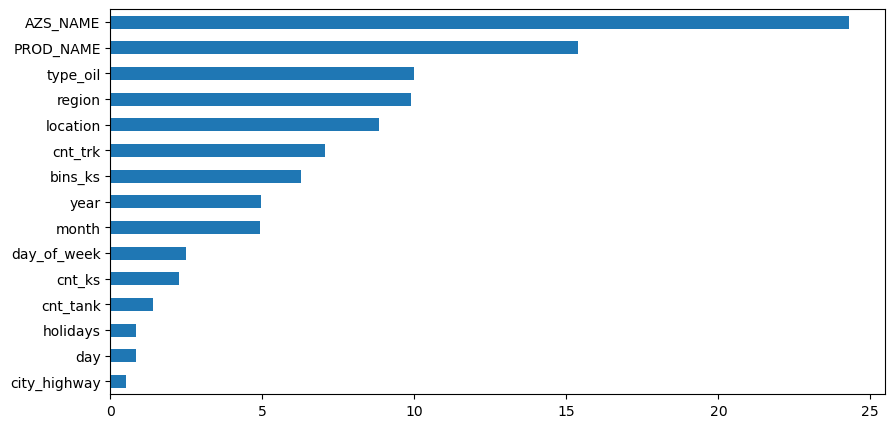

In [70]:
feature_imp_cat = pd.Series(cat_optuna.feature_importances_, index=X.columns)
feature_imp_cat.nlargest(15).sort_values(ascending=True).plot(kind='barh',
                                                              figsize=(10, 5));
plt.show();

Топ 5 важных признаков:  
- AZS_NAME
- PROD_NAME
- type_oil
- region
- location

## Best params, fit CV + holdout

In [71]:
def cross_validation_cat(X_train: pd.DataFrame,
                         y_train: pd.Series,
                         X_test: pd.DataFrame,
                         y_test: pd.Series,
                         clf,
                         params: dict,
                         cat_features: list = None,
                         eval_metric: str = None,
                         early_stop: bool = False,
                         early_stopping_rounds: int = 100,
                         num_folds: int = 5,
                         random_state: int = 10,
                         shuffle: bool = True):
    
    """Получение результатов при помощи кросс-валидации для задачи РЕГРЕССИИ"""
    
    # shuffle - перемешивание данных только перед разбиением
    folds = KFold(n_splits=num_folds, random_state=random_state, shuffle=shuffle)
    score_oof = []
    predictions_test = []

    for fold, (train_index,
               test_index) in enumerate(folds.split(X_train, y_train)):
        X_train_, X_val = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_, y_val = y_train.iloc[train_index], y_train.iloc[test_index]

        model = clf(**params)

        if early_stop == True:
            if eval_metric is None:
                model.fit(X_train_,
                          y_train_,
                          eval_set=[(X_val, y_val)],
                          cat_features=cat_features,
                          silent=True,
                          early_stopping_rounds=early_stopping_rounds)
            else:
                model.fit(X_train_,
                          y_train_,
                          eval_set=[(X_val, y_val)],
                          eval_metric=eval_metric,
                          silent=True,
                          cat_features=cat_features,
                          early_stopping_rounds=early_stopping_rounds)
        else:
            model.fit(X_train_, y_train_, cat_features=cat_features)

        y_pred_val = model.predict(X_val)
        y_pred = model.predict(X_test)

        print(
            "Fold:", fold + 1,
            "MAE SCORE %.5f" % mean_absolute_error(y_val, y_pred_val))
        print("---")

        # oof list
        score_oof.append(mean_absolute_error(y_val, y_pred_val))
        # holdout list
        predictions_test.append(y_pred)

    return score_oof, predictions_test

In [72]:
study_cat.best_params

{'n_estimators': 3000,
 'learning_rate': 0.14295150734048512,
 'max_depth': 10,
 'colsample_bylevel': 0.8193474487801746,
 'l2_leaf_reg': 1.3545777239111751,
 'random_strength': 38.36050116280313,
 'bootstrap_type': 'Bernoulli',
 'border_count': 128,
 'grow_policy': 'SymmetricTree',
 'od_wait': 1689,
 'leaf_estimation_iterations': 13,
 'loss_function': 'MAE',
 'use_best_model': True,
 'eval_metric': 'MAE',
 'subsample': 0.7185613400735754}

In [73]:
cat_best = {
    'n_estimators': 3000,
    'learning_rate': 0.14295150734048512,
    'max_depth': 10,
    'colsample_bylevel': 0.8193474487801746,
    'l2_leaf_reg': 1.3545777239111751,
    'random_strength': 38.36050116280313,
    'bootstrap_type': 'Bernoulli',
    'border_count': 128,
    'grow_policy': 'SymmetricTree',
    'od_wait': 1689,
    'leaf_estimation_iterations': 13,
    'loss_function': 'MAE',
    'use_best_model': True,
    'eval_metric': 'MAE',
    'subsample': 0.7185613400735754
}

score_oof, predictions_test = cross_validation_cat(
    X_train,
    y_train,
    X_test,
    y_test,
    early_stop=True,
    cat_features=cat_features,
    early_stopping_rounds=50,
    num_folds=N_FOLDS,
    clf=CatBoostRegressor,
    params=cat_best)

Fold: 1 MAE SCORE 0.26044
---
Fold: 2 MAE SCORE 0.26178
---
Fold: 3 MAE SCORE 0.26164
---
Fold: 4 MAE SCORE 0.26150
---
Fold: 5 MAE SCORE 0.25887
---


In [74]:
test_pred = np.mean(predictions_test, axis=0)

print('MAE mean OOF: %.3f, std: %.3f' %
      (np.mean(score_oof), np.std(score_oof)))
print('MAE HOLDOUT: %.3f' % mean_absolute_error(y_test, test_pred))

MAE mean OOF: 0.261, std: 0.001
MAE HOLDOUT: 0.256


In [75]:
metrics = pd.concat([metrics, get_metrics_regression(y_test=y_test,
                                                     y_pred=test_pred,
                                                     X_test=X_test,
                                                     name='CatBoost_best_CV_Holdout')])
metrics

,model,MAE,MSE,RMSE,RMSLE,R2 adjusted,MPE_%,MAPE_%,WAPE_%
0,CatBoost_eval_baseline,0.318326,0.238707,0.488577,None,0.925889,NaN,inf,17.333156
0,LGBMRegressor_baseline,0.332521,0.321677,0.567166,None,0.900129,NaN,inf,18.106082
0,CatBoost_RandGrid,0.286569,0.220413,0.469482,None,0.931569,NaN,inf,15.603974
0,CatBoost_Optuna,0.261691,0.180969,0.425405,None,0.943815,NaN,inf,14.249330
0,CatBoost_best_CV_Holdout,0.255648,0.173391,0.416402,None,0.946168,NaN,inf,13.920277


In [76]:
metrics.drop(['RMSLE', 'MPE_%', 'MAPE_%'], axis=1)

,model,MAE,MSE,RMSE,R2 adjusted,WAPE_%
0,CatBoost_eval_baseline,0.318326,0.238707,0.488577,0.925889,17.333156
0,LGBMRegressor_baseline,0.332521,0.321677,0.567166,0.900129,18.106082
0,CatBoost_RandGrid,0.286569,0.220413,0.469482,0.931569,15.603974
0,CatBoost_Optuna,0.261691,0.180969,0.425405,0.943815,14.249330
0,CatBoost_best_CV_Holdout,0.255648,0.173391,0.416402,0.946168,13.920277


Вывод:  
при holdout на тестовой выборке самые лучшие метрики по сравнению с предыдущими алгоритмами

In [78]:
joblib.dump(rgr_cb, "rgr_cb.pkl")
joblib.dump(rgr_lgbm, "rgr_lgbm.pkl")
joblib.dump(cat_grid, "cat_grid.pkl")
joblib.dump(cat_optuna, "cat_optuna.pkl")

['cat_optuna.pkl']

# 6. Стекинг  

## Sklearn

Для стэкинга буду использовать 4 модели:
* LightGBM (baseline)  
* CatBoost (baseline)  
* CatBoost (tuning на гиперпараметрах подобранных с помощью greadsearch)  
* CatBoost (tuning на гиперпараметрах подобранных с помощью optuna)  
В качестве финальной метамодели буду использовать линейную регрессию  

In [55]:
df = pd.read_csv(r"C:\Users\ozhiganov_dv\Jupyter\PyMagic\09. Pet-project\data\df_2")
cat_cols = df.select_dtypes('object').columns
df[cat_cols] = df[cat_cols].astype("category")
cat_features = X_train.select_dtypes('category').columns.tolist()

In [56]:
X = df.drop(['MASSA_TN'], axis=1)
y = df['MASSA_TN']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    random_state=RAND)

In [254]:
optuna_params = {
    'n_estimators': 3000,
    'learning_rate': 0.14295150734048512,
    'max_depth': 10,
    'colsample_bylevel': 0.8193474487801746,
    'l2_leaf_reg': 1.3545777239111751,
    'random_strength': 38.36050116280313,
    'bootstrap_type': 'Bernoulli',
    'border_count': 128,
    'grow_policy': 'SymmetricTree',
    'od_wait': 1689,
    'leaf_estimation_iterations': 13,
    'loss_function': 'MAE',
    'eval_metric': 'MAE',
    'subsample': 0.7185613400735754
}

In [255]:
grid_search_params = {
    'border_count': 100,
    'random_seed': 10,
    'depth': 7,
    'iterations': 3000,
    'learning_rate': 0.1,
    'l2_leaf_reg': 0.0005623413251903491,
    'grow_policy': 'SymmetricTree',
    'boosting_type': 'Ordered',
    'bootstrap_type': 'No'
}

In [256]:
estimators = [('lgbm', LGBMRegressor()),
              ('cb_1', CatBoostRegressor(eval_metric="MAE",
                                         verbose=500,
                                         cat_features=cat_features)),
              ('cb_2', CatBoostRegressor(**optuna_params,
                                         cat_features=cat_features,
                                         verbose=1000)),
              ('cb_3', CatBoostRegressor(**grid_search_params,
                                         eval_metric="MAE",
                                         loss_function='MAE',
                                         cat_features=cat_features,
                                         verbose=1000)),]

In [257]:
final_estimator = LinearRegression()
reg = StackingRegressor(estimators=estimators,
                        final_estimator=final_estimator)

In [258]:
reg.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017881 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 377
[LightGBM] [Info] Number of data points in the train set: 710094, number of used features: 17
[LightGBM] [Info] Start training from score 1.835071
Learning rate set to 0.115528
0:	learn: 1.2165500	total: 335ms	remaining: 5m 34s
500:	learn: 0.3585382	total: 3m 9s	remaining: 3m 8s
999:	learn: 0.3282604	total: 6m 19s	remaining: 0us
0:	learn: 1.1525691	total: 657ms	remaining: 32m 50s
1000:	learn: 0.2592787	total: 14m 39s	remaining: 29m 15s
2000:	learn: 0.2479179	total: 29m 25s	remaining: 14m 41s
2999:	learn: 0.2427406	total: 44m 13s	remaining: 0us
0:	learn: 1.1510759	total: 798ms	remaining: 39m 52s
1000:	learn: 0.3156728	total: 15m 3s	remaining: 30m 4s
2000:	learn: 0.2946734	total: 29m 27s	remaining: 14m 42s
2999:	learn: 0.2858955	tota

StackingRegressor(estimators=[('lgbm', LGBMRegressor()),
                              ('cb_1',
                               <catboost.core.CatBoostRegressor object at 0x00000209058F10D0>),
                              ('cb_2',
                               <catboost.core.CatBoostRegressor object at 0x00000209058F1B50>),
                              ('cb_3',
                               <catboost.core.CatBoostRegressor object at 0x00000209058F1AC0>)],
                  final_estimator=LinearRegression())

In [259]:
y_pred_2 = reg.predict(X_test)
print('R2 score: {:.2f}'.format(r2_score(y_test, y_pred_2)))

R2 score: 0.95


In [260]:
get_metrics_regression(y_test=y_test,
                       y_pred=y_pred_2,
                       X_test=X_test,
                       name='Stacking_Sklearn')

,model,MAE,MSE,RMSE,RMSLE,R2 adjusted,MPE_%,MAPE_%,WAPE_%
0,Stacking_Sklearn,0.256047,0.168581,0.410586,None,0.947661,NaN,inf,13.942003


In [262]:
check_overfitting(reg, X_train, y_train, X_test, y_test, mean_absolute_error)

mean_absolute_error train: 0.244
mean_absolute_error test: 0.256
delta = 4.9 %


In [261]:
joblib.dump(reg, "stacking_sklearn.pkl")

['stacking_sklearn.pkl']

Вывод:  
При использование ансамблей моделей (стэкинг) результаты получились немного хуже чем при обучении на кросс валидации.  
То есть из всех рассмотренных алгоритмов лучшие метрики:  
* при применении кросс-валидации  
* ансамблировании с помощью стэкинга  